In [24]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
train_df = pd.read_csv(r"..\..\data\training_data.csv")

In [26]:
train_df.shape

(6235, 17)

In [27]:
y_train = train_df["selling_price"]
X_train = train_df.drop(columns=["selling_price"])

In [28]:
X_train = sm.add_constant(X_train)

In [29]:
ols_model = sm.OLS(y_train, X_train).fit()

In [30]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     791.3
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        01:06:08   Log-Likelihood:                 10711.
No. Observations:                6235   AIC:                        -2.139e+04
Df Residuals:                    6218   BIC:                        -2.127e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [31]:
with open("currentOlsSolution.pkl", "wb") as file:
    pickle.dump(ols_model, file)

print("OLS model saved as 'currentOlsSolution.pkl'")


OLS model saved as 'currentOlsSolution.pkl'


In [32]:
with open("currentOlsSolution.pkl", "rb") as file:
    loaded_model = pickle.load(file)

In [34]:
test_df = pd.read_csv(r"..\..\data\test_data.csv")

X_test = sm.add_constant(test_df.drop(columns=["selling_price"]))
y_test = test_df['selling_price']

y_pred = loaded_model.predict(X_test)

print(y_pred)


0      -0.037492
1       0.061845
2       0.086335
3       0.350976
4       0.096100
          ...   
1554    0.056493
1555   -0.016359
1556    0.221373
1557    0.092933
1558    0.055851
Length: 1559, dtype: float64


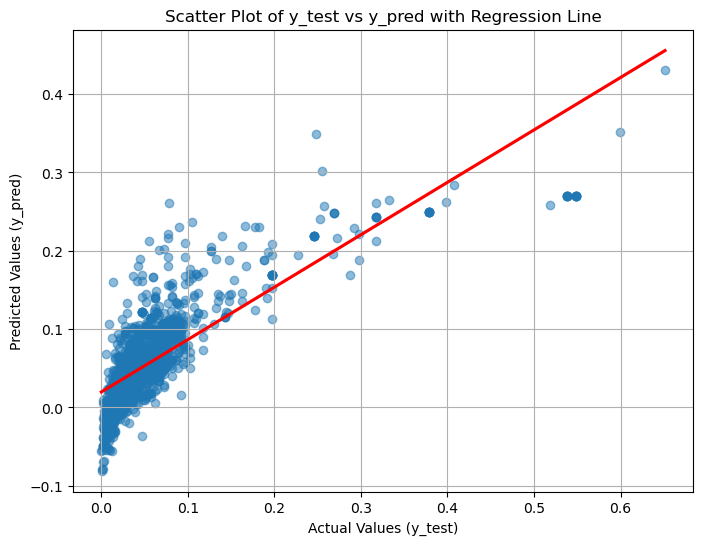

In [40]:
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ci=None)

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Scatter Plot of y_test vs y_pred with Regression Line')
plt.grid(True)

# Save plot
plt.savefig('../../documentation/scatter_regression_plot_OLSModel.png', dpi=300)

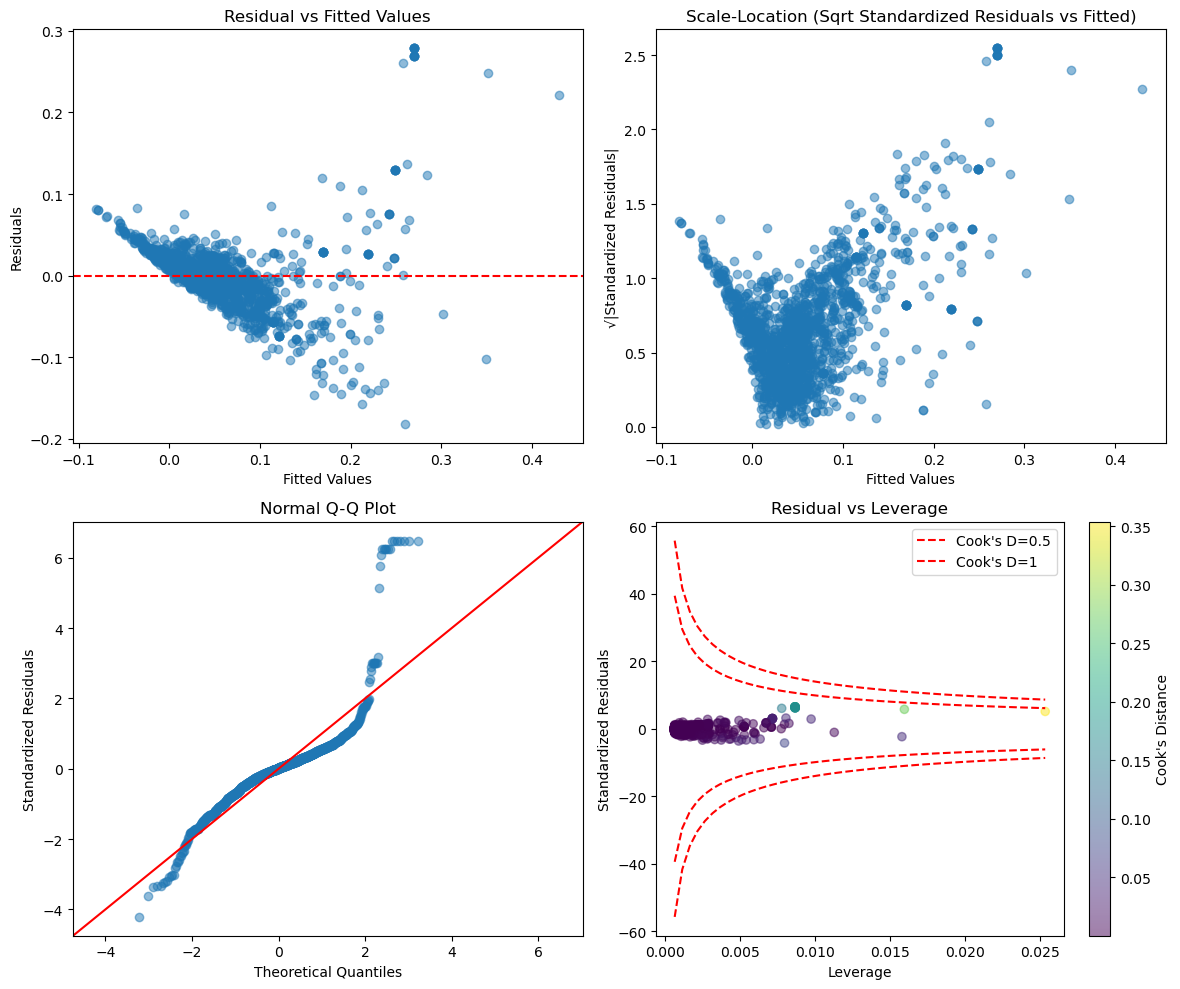

In [39]:
residuals = y_test - y_pred
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Calculate leverage using hat matrix
X = sm.add_constant(np.column_stack([np.ones_like(y_pred), y_pred]))  # Simple example matrix
hat_matrix = X @ np.linalg.inv(X.T @ X) @ X.T
leverage = np.diag(hat_matrix)

#Cook's distance
cooks_d = (standardized_residuals ** 2) * leverage / (X.shape[1] * (1 - leverage) ** 2)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residual vs Fitted values
axes[0, 0].scatter(y_pred, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residual vs Fitted Values')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')

# 2. Square Root of Standardized Residuals vs Fitted values
sqrt_abs_resid = np.sqrt(np.abs(standardized_residuals))
axes[0, 1].scatter(y_pred, sqrt_abs_resid, alpha=0.5)
axes[0, 1].set_title('Scale-Location (Sqrt Standardized Residuals vs Fitted)')
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('√|Standardized Residuals|')

# 3. Q-Q plot of Standardized Residuals
sm.qqplot(standardized_residuals, line='45', fit=True, alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')
axes[1, 0].set_xlabel('Theoretical Quantiles')
axes[1, 0].set_ylabel('Standardized Residuals')

# 4. Residual vs Leverage with Cook's distance contours
scatter = axes[1, 1].scatter(leverage, standardized_residuals, alpha=0.5, c=cooks_d, cmap='viridis')
axes[1, 1].set_title('Residual vs Leverage')
axes[1, 1].set_xlabel('Leverage')
axes[1, 1].set_ylabel('Standardized Residuals')

# Add Cook's distance contours
x = np.linspace(min(leverage), max(leverage), 50)
for c in [0.5, 1]:
    axes[1, 1].plot(x, np.sqrt((c * X.shape[1] * (1 - x) ** 2) / x),
                    label=f"Cook's D={c}", linestyle='--', color='red')
    axes[1, 1].plot(x, -np.sqrt((c * X.shape[1] * (1 - x) ** 2) / x),
                    linestyle='--', color='red')

axes[1, 1].legend()
fig.colorbar(scatter, ax=axes[1, 1], label="Cook's Distance")

plt.tight_layout()
plt.savefig('../../documentation/diagnostic_plots_OLSModel.png', dpi=300)
plt.show()